In [2]:
! nvidia-smi

Sat May 13 14:43:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 w...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P8                8W /  N/A|    716MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [95]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

pretrain_weight = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

model_ft = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=pretrain_weight)

model_ft.roi_heads.box_predictor = FastRCNNPredictor(1024, 2)

net = model_ft.to(device)

C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [89]:
class_ = ["banner"]
textlabel2num = {'banner':1}
numlabel2text = {1:'banner'}

In [85]:
from bs4 import BeautifulSoup 

# Reading the data inside the xml file to a variable under the name  data
def get_target(xml_file):
    labels = []
    boxes = []
    with open(xml_file, 'r') as f:
        data = f.read() 

    # Passing the stored data inside the beautifulsoup parser 
    data = BeautifulSoup(data, 'xml')
    # print(data.annotation.object)
    for item in data.annotation.find_all('object'):
#         print(item)
        labels.append(1)
        box = item.bndbox
#         print(box)
#         print(box.xmin.text, box.ymin.text, box.xmax.text, box.ymax.text)
        boxes.append([
            np.float32(box.xmin.text),
            np.float32(box.ymin.text),
            np.float32(box.xmax.text),
            np.float32(box.ymax.text)
        ])
    f.close()
    labels = torch.as_tensor(labels, dtype=torch.int64).to(device)
    boxes = torch.as_tensor(boxes, dtype=torch.float32).to(device)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    return target

In [77]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
class BannerDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_list = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        img_name = os.path.join(self.root_dir, self.data_list.iloc[idx, 0]+'.jpg')
        img = Image.open(img_name).convert('RGB')
        X = img
        if self.transform:
            X = self.transform(X)
        X = X.to(device)
        target = get_target('data/label/'+self.data_list.iloc[idx, 0]+'.xml')
        return X, target

In [78]:
def collate_fn(batch):
    X, y = tuple(zip(*batch))
    return list(X), list(y)

In [99]:
dataset = BannerDataset(csv_file='data_list.csv', root_dir='data/img/', transform=transform_train)
trainset, valtestset = torch.utils.data.random_split(dataset, [500, 185])
valset, testset = torch.utils.data.random_split(valtestset, [100, 85])

trainloader = DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valloader = DataLoader(valset, batch_size=16, shuffle=False, collate_fn=collate_fn)
testloader = DataLoader(testset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [100]:
print(trainset.__len__(), valset.__len__(), testset.__len__())

500 100 85


In [101]:
from tqdm import tqdm

In [102]:
trainset.__getitem__(0)

(tensor([[[ 0.5373,  0.5373,  0.5373,  ...,  0.2471,  0.2627,  0.2627],
          [ 0.5373,  0.5373,  0.5373,  ...,  0.2471,  0.2627,  0.2627],
          [ 0.5373,  0.5451,  0.5373,  ...,  0.2471,  0.2627,  0.2627],
          ...,
          [ 0.0353,  0.0745, -0.0039,  ...,  0.0745,  0.0118, -0.0667],
          [ 0.0902,  0.1216,  0.0353,  ...,  0.0431, -0.0039, -0.0667],
          [ 0.1529,  0.1765,  0.0745,  ...,  0.0196, -0.0118, -0.0431]],
 
         [[ 0.7490,  0.7490,  0.7647,  ...,  0.4824,  0.4902,  0.4902],
          [ 0.7490,  0.7490,  0.7647,  ...,  0.4824,  0.4902,  0.4902],
          [ 0.7490,  0.7569,  0.7647,  ...,  0.4824,  0.4902,  0.4902],
          ...,
          [ 0.0588,  0.0980,  0.0196,  ...,  0.0667,  0.0039, -0.0745],
          [ 0.1137,  0.1451,  0.0588,  ...,  0.0353, -0.0118, -0.0745],
          [ 0.1765,  0.2000,  0.0980,  ...,  0.0118, -0.0196, -0.0510]],
 
         [[ 0.6000,  0.6000,  0.5922,  ...,  0.7804,  0.8039,  0.8039],
          [ 0.6000,  0.6000,

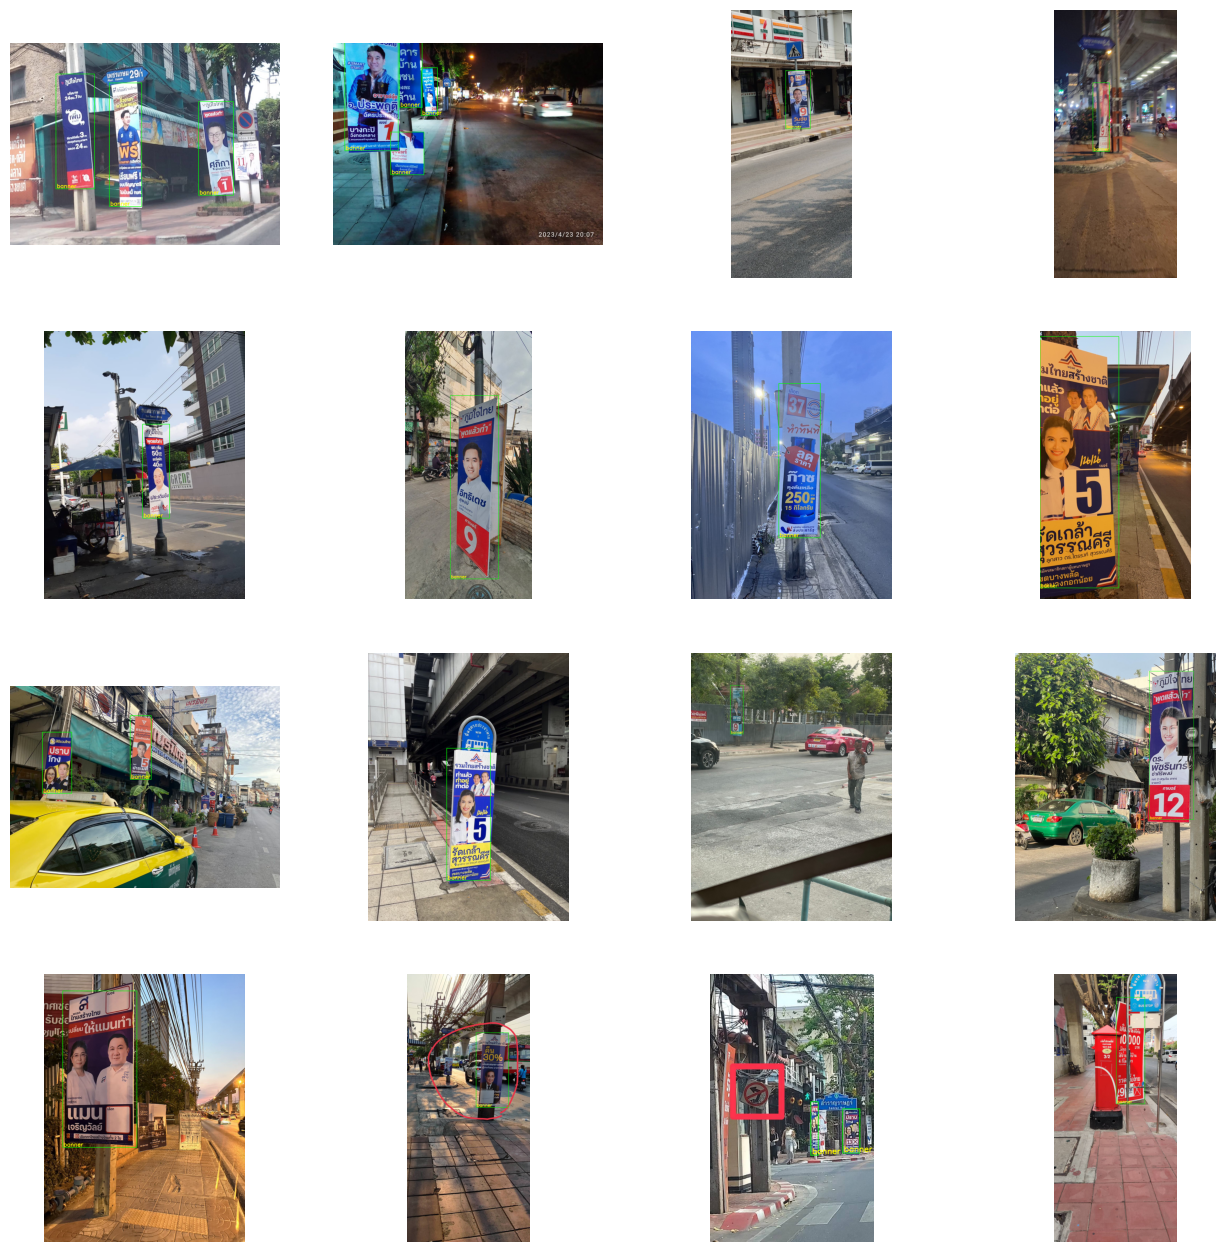

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# functions to show an image
def imshow(imgs, labels, ncol):
    nrow = len(imgs) // ncol
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))
    for row in range(nrow):
        for col in range(ncol):
            if row*ncol + col < len(imgs):
                img = imgs[row*ncol + col].cpu()*0.5 + 0.5
                img = img.permute((1, 2, 0)).mul(255).numpy()
                img = np.ascontiguousarray(img, dtype=np.uint8)
                
                boxes = labels[row*ncol + col]['boxes'].cpu().numpy()
                in_labels = labels[row*ncol + col]['labels'].cpu().numpy()
                nbox, _ = boxes.shape
                
                for i in range(nbox):
                    img = cv2.rectangle(img = img, 
                                        pt1 = (int(boxes[i][0]), int(boxes[i][1])), 
                                        pt2 = (int(boxes[i][2]), int(boxes[i][3])), 
                                        color = (0, 255, 0), 
                                        thickness = 2)
                    
                    img = cv2.putText(img = img, 
                                      text = f'{numlabel2text[in_labels[i]]}', 
                                      org = (int(boxes[i][0]) + 5, int(boxes[i][3]) - 5 ), 
                                      fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                                      fontScale = 1,
                                      color = (255, 255, 0), 
                                      thickness = 2, 
                                      lineType = cv2.LINE_AA)
                
                ax[row, col].imshow(img)
                ax[row, col].axis('off')
            else:
                ax[row, col].imshow(np.zeros((200,200, 3), dtype = np.uint8))
                ax[row, col].axis('off')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
ncol = 4
imshow(images, labels, ncol)

In [104]:
def single_iou(gt_box, pred_box):
    gt_box = gt_box.cpu()
    pred_box = pred_box.cpu()
    
    intersec_box = torch.tensor([
        max(gt_box[0], pred_box[0]),
        max(gt_box[1], pred_box[1]),
        min(gt_box[2], pred_box[2]),
        min(gt_box[3], pred_box[3])
    ])
    
    intersec_w = max(intersec_box[2]-intersec_box[0], 0)
    intersec_h = max(intersec_box[3]-intersec_box[1], 0)
    intersec_area = intersec_w * intersec_h
    
    gt_w = gt_box[2] - gt_box[0]
    gt_h = gt_box[3] - gt_box[1]
    gt_area = gt_w*gt_h
    
    pred_w = pred_box[2] - pred_box[0]
    pred_h = pred_box[3] - pred_box[1]
    pred_area = pred_w*pred_h
    
    iou = intersec_area / (pred_area+gt_area-intersec_area)
    
    return iou

In [105]:
def miou(pred, gt):
    mIoU = 0
    for i in range(len(gt)):
        pred_ = pred[i]
        gt_ = gt[i]
        mIoU_image = 0
        n_box = 0
        
        for pred_box, pred_label in zip(pred_['boxes'], pred_['labels']):
            max_iou = 0
            for gt_box, gt_label in zip(gt_['boxes'], gt_['labels']):
                iou = single_iou(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
            mIoU_image += max_iou
            n_box += 1
            
        for gt_box, gt_label in zip(gt_['boxes'], gt_['labels']):
            max_iou = 0
            for pred_box, pred_label in zip(pred_['boxes'], pred_['labels']):
                iou = single_iou(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
            mIoU_image += max_iou
            n_box += 1
        
        if n_box:
            mIoU_image /= n_box
        else:
            mIoU_image = 0
        mIoU += mIoU_image
    mIoU /= len(gt)
    
    return mIoU, len(gt)
        

In [106]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [107]:
epochs = 5
history_train = {'loss_classifier':np.zeros(epochs), 'loss_box_reg':np.zeros(epochs), 'loss_objectness':np.zeros(epochs), 'loss_rpn_box_reg':np.zeros(epochs), 'iou':np.zeros(epochs), 'ap@50':np.zeros(epochs)}
history_val = {'loss_classifier':np.zeros(epochs), 'loss_box_reg':np.zeros(epochs), 'loss_objectness':np.zeros(epochs), 'loss_rpn_box_reg':np.zeros(epochs), 'iou':np.zeros(epochs), 'ap@50':np.zeros(epochs)}
max_val_iou = 0
PATH = "weight.pth"

for epoch in range(epochs):
    print(f'epoch {epoch+1} \nTraining...')
    mIoU = 0
    training_loss = 0.0
    training_loss_classifier = 0.0
    training_loss_box_reg = 0.0
    training_loss_objectness = 0.0
    training_loss_rpn_box_reg = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            inputs, labells = data
            
            optimizer.zero_grad()
            
            net.train()
            loss_dict = net(inputs, labels)
            loss = sum(x for x in loss_dict.values())
            
            loss.backward()
            
            optimizer.step()
            
            with torch.no_grad():
                net.eval()
                preds = net(inputs)
                mIoU_sample, n_sample = miou(preds, labels)
            
            training_loss += loss.item()*n_sample
            training_loss_classifier += loss_dict['loss_classifier'].item()*n_sample
            training_loss_box_reg += loss_dict['loss_box_reg'].item()*n_sample
            training_loss_objectness += loss_dict['loss_objectness'].item()*n_sample
            training_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()*n_sample
            mIoU += mIoU_sample*n_sample
            n += n_sample
            
    scheduler.step()
    
    training_loss /= n
    training_loss_classifier /= n
    training_loss_box_reg /= n
    training_loss_objectness /= n
    training_loss_rpn_box_reg /= n
    mIoU /= n
    print(f'total_training_loss: {training_loss:.4}, loss_classifier: {training_loss_classifier:.4}, loss_box_reg: {training_loss_box_reg:.4}, loss_objectness: {training_loss_objectness:.4}, loss_rpn_box_reg: {training_loss_rpn_box_reg:.4}, mIoU: {mIoU:.4}')
    history_train['loss_classifier'][epoch] = training_loss_classifier
    history_train['loss_box_reg'][epoch] = training_loss_box_reg
    history_train['loss_objectness'][epoch] = training_loss_objectness
    history_train['loss_rpn_box_reg'][epoch] = training_loss_rpn_box_reg
    history_train['iou'][epoch] = mIoU
    
    print('validating...')
    mIoU = 0
    validation_loss = 0.0
    validation_loss_classifier = 0.0
    validation_loss_box_reg = 0.0
    validation_loss_objectness = 0.0
    validation_loss_rpn_box_reg = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labells = data
            
            net.eval()
            preds = net(inputs)
            mIoU_sample, n_sample = miou(preds, labels)
            
            net.train()
            loss_dict = net(inputs, labels)
            loss = sum(x for x in loss_dict.values())
            
            
            optimizer.zero_grad()
            
            
            validation += loss.item()*n_sample
            validation_loss_classifier += loss_dict['loss_classifier'].item()*n_sample
            validation_loss_box_reg += loss_dict['loss_box_reg'].item()*n_sample
            validation_loss_objectness += loss_dict['loss_objectness'].item()*n_sample
            validation_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()*n_sample
            mIoU += mIoU_sample*n_sample
            n += n_sample
            
    
    validation_loss /= n
    validation_loss_classifier /= n
    validation_loss_box_reg /= n
    validation_loss_objectness /= n
    validation_loss_rpn_box_reg /= n
    mIoU /= n
    print(f'total_validation_loss: {validation_loss:.4}, loss_classifier: {validation_loss_classifier:.4}, loss_box_reg: {validation_loss_box_reg:.4}, loss_objectness: {validation_loss_objectness:.4}, loss_rpn_box_reg: {validation_loss_rpn_box_reg:.4}, mIoU: {mIoU:.4}')
    history_val['loss_classifier'][epoch] = validation_loss_classifier
    history_val['loss_box_reg'][epoch] = validation_loss_box_reg
    history_val['loss_objectness'][epoch] = validation_loss_objectness
    history_val['loss_rpn_box_reg'][epoch] = validationloss_rpn_box_reg
    history_val['iou'][epoch] = mIoU
    
    if mIoU > max_val_iou:
        torch.save(net.state_dict(), PATH)
        max_val_iou = mIoU

print('Finished Training!')

epoch 1 
Training...


  0%|          | 0/32 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 280.00 MiB (GPU 0; 8.00 GiB total capacity; 6.96 GiB already allocated; 0 bytes free; 7.20 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF